# Correlation between Attention and Attribution by IG on BERT

In [1]:
!pip install transformers
!pip install captum
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.1 MB/s eta 0:00:00


# Mask Language Modeling

#### lib

In [12]:
import os
import scipy
import numpy as np

from tqdm import tqdm

import random
from torch.utils.data import Sampler

import torch
import random

from captum.attr import LayerConductance
from captum.attr import configure_interpretable_embedding_layer, remove_interpretable_embedding_layer

from datasets import Dataset
from transformers import PreTrainedTokenizer, DataCollatorForLanguageModeling

def predict(model, inputs, token_type_ids=None, position_ids=None, attention_mask=None):

    output = model(inputs, token_type_ids=token_type_ids,
                 position_ids=position_ids, attention_mask=attention_mask, )

    return output.attentions

def squad_pos_forward_func(inputs, model, attention_mask=None, target=None):
    '''
      Notes:
        1. The need of target is necessary when the output is multi-dimensional.
    '''
    output = model(inputs_embeds=inputs, attention_mask=attention_mask )

    return output.logits.max(1).values if target==None else output.logits

def normalize_columns(dataset: Dataset, old_name: str, new_name: str):
    """
    Renames a column in the dataset and drop all but 'label' and 'text'.

    Args:
    dataset (Dataset): The HuggingFace dataset to process.
    old_name (str): The current name of the column to be renamed.
    new_name (str): The new name for the column.

    Returns:
    Dataset: The dataset with the renamed column.
    """

    # Check if the old column name exists in the dataset
    if old_name in dataset.column_names:
        # Rename the column
        dataset = dataset.rename_column(old_name, new_name)
    else:
        print(f"The column '{old_name}' does not exist in the dataset.")

    # List all columns except 'label'
    to_be_removed = [col for col in dataset.column_names if col != 'label' and col != 'text']

    dataset = dataset.remove_columns(to_be_removed)

    return dataset

def tokenize_and_filter(dataset: Dataset, tokenizer: PreTrainedTokenizer, max_token_length: int = 200, batch_size: int = 1000):
    """
    Tokenizes the sentences in the dataset and filters out examples with more than max_token_length tokens.

    Args:
    dataset (Dataset): The HuggingFace dataset to process.
    tokenizer (PreTrainedTokenizer): The tokenizer to use for tokenizing the sentences.
    max_token_length (int): Maximum allowed token length for each example.

    Returns:
    Dataset: A new dataset with tokenized sentences and filtered based on token length.
    """

    def batch_tokenize(examples):

      tokens = [tokenizer.tokenize(text) for text in examples['text']]

      return {'tokens': tokens, 'label': examples['label']}

    # Tokenize the dataset
    tokenized_dataset = dataset.map(
        batch_tokenize,
        batched=True,
        batch_size=batch_size,
        remove_columns=['text']
    )

    # Filter the dataset to keep examples with <= max_token_length tokens
    filtered_dataset = tokenized_dataset.filter(
        lambda example: len(example['tokens']) <= max_token_length
    )

    return filtered_dataset


class MovieReviewDataset(torch.utils.data.Dataset):
  def __init__(self, reviews, targets, tokenizer):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer

  def __len__(self):
    return len(self.reviews)

  # The sentence is alreadt tokenized
  def __getitem__(self, item):
    tokens = self.reviews[item]
    target = self.targets[item]

    return tokens, target

def create_data_loader(df, batch_size, tokenizer, collator, bucket_sampling=False, shuffle=False):

  ds = MovieReviewDataset(
    reviews=df.tokens.to_numpy(),
    targets=df.label.to_numpy(),
    tokenizer=tokenizer
  )

  # Implement Bucket Sampling
  if bucket_sampling:
    return torch.utils.data.DataLoader(
        ds,
        batch_sampler=BatchSamplerSimilarLength(dataset=ds, batch_size=batch_size, shuffle=shuffle),
        collate_fn=collator
    )

  return torch.utils.data.DataLoader(
    ds,
    batch_size=batch_size,
    collate_fn=collator
  )

def get_predictions(model, device, data_loader):
  '''
  Notes for MLM model:
    1. The MLM model finally produces a tensor (batch, tokens, vocab_size), that for every token
    produces a probability for each token in the vocab. Based on each fine tuning task, we add the
    appropriate head in the end and make the choise.
  '''
  total_attentions = []

  with torch.no_grad():
    for d in tqdm(data_loader, total=len(data_loader), desc="Extracting Attention Weights", ncols=75, leave=True, bar_format="{l_bar}{bar}| {n_fmt}/{total_fmt}"):

      # we do not use 'label' as we do no care about the loss
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      print(input_ids.shape)

      attentions = predict(
        model,
        inputs=input_ids,
        attention_mask=attention_mask
      )

      # stack all the layers -> layer x batch x head x tokens x tokens
      attentions_stack = torch.stack(tuple(i.detach().clone().cpu() for i in attentions)) # transfer data from cuda to cpu, therefore attentions_stack is on CPU

      del attentions
      torch.cuda.empty_cache()

      # stack all the attentions of the spescific batch -> layer x batch x head x tokens x tokens
      total_attentions.append(attentions_stack.detach().clone().cpu())
      # total_attentions = torch.cat((total_attentions, attentions_stack), dim=1)

      del attentions_stack
      torch.cuda.empty_cache()

  return total_attentions

def get_interpretability_scores(model, device, data_loader, target=None):
  '''
    Notes:
      1. In the source code for LayerConductance.attribute() all the helper-functions
      that are called, activate the grad computation (requires_grad=True) before start
      the calculation.
      https://github.com/pytorch/captum/blob/ed3b1fa4b3d8afc0eff4179b1d1ef4b191f13cc1/captum/_utils/gradient.py#L589
  '''
  interpretable_embedding = configure_interpretable_embedding_layer(model, 'bert.embeddings.word_embeddings')
  try:
    total_attributions = []
    for d in tqdm(data_loader, total=len(data_loader), desc="Calculating Attribution Scores", ncols=75, leave=True, bar_format="{l_bar}{bar}| {n_fmt}/{total_fmt}"):

      input_ids = d["input_ids"].to(device)
      ref_input_ids = d["ref_input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)

      print(input_ids.shape)

      input_embeddings = interpretable_embedding.indices_to_embeddings(input_ids)
      ref_input_embeddings = interpretable_embedding.indices_to_embeddings(ref_input_ids)

      layer_attn_mat = []
      for i in range(model.config.num_hidden_layers):
        lc = LayerConductance(squad_pos_forward_func, model.bert.encoder.layer[i])
        layer_attributions = lc.attribute(inputs=input_embeddings, baselines=ref_input_embeddings, target=target, additional_forward_args=(model, attention_mask, target))
        layer_attn_mat.append(layer_attributions[1].detach().clone().cpu()) # convert into cpu memory and the delete from cuda to avoid memory leak

        # Delete intermediate tensors to free up memory
        del layer_attributions, lc
        torch.cuda.empty_cache()

      # stack all the layers -> layer x batch x head x tokens x tokens
      layer_attn_mat = torch.stack(layer_attn_mat)

      del input_ids, ref_input_ids, attention_mask, input_embeddings, ref_input_embeddings
      torch.cuda.empty_cache()

      # # stack all the attentions of the specific batch -> layer x batch x head x tokens x tokens
      total_attributions.append(layer_attn_mat.detach().clone().cpu())

      del layer_attn_mat
      torch.cuda.empty_cache()

    # total_attributions = torch.cat(attributions_list, dim=1)

  finally:
    # after we finish the interpretation we need to remove
    # interpretable embedding layer with the following command:
    remove_interpretable_embedding_layer(model, interpretable_embedding)


  return total_attributions

def get_interpretability_scores2(model, device, data_loader, _target=None, mlm=False):
  '''
    Notes:
      1. In the source code for LayerConductance.attribute() all the helper-functions
      that are called, activate the grad computation (requires_grad=True) before start
      the calculation.
      https://github.com/pytorch/captum/blob/ed3b1fa4b3d8afc0eff4179b1d1ef4b191f13cc1/captum/_utils/gradient.py#L589
  '''
  interpretable_embedding = configure_interpretable_embedding_layer(model, 'bert.embeddings.word_embeddings')
  try:
    total_attributions = []
    for d in tqdm(data_loader, total=len(data_loader), desc="Calculating Attribution Scores", ncols=75, leave=True, bar_format="{l_bar}{bar}| {n_fmt}/{total_fmt}"):

      _input_ids = d["input_ids"]
      _ref_input_ids = d["ref_input_ids"]
      _attention_mask = d["attention_mask"]
      print('_input_ids.shape', _input_ids.shape)

      # BertForLanguafeModeling
      _target = d["target"] if mlm else _target

      attribution_list_of_copies = []
      for (input_ids, ref_input_ids, attention_mask, target) in zip(_input_ids, _ref_input_ids, _attention_mask, _target):
        input_ids = input_ids.unsqueeze(0).to(device)
        ref_input_ids = ref_input_ids.unsqueeze(0).to(device)
        attention_mask = attention_mask.unsqueeze(0).to(device)

        input_embeddings = interpretable_embedding.indices_to_embeddings(input_ids)
        ref_input_embeddings = interpretable_embedding.indices_to_embeddings(ref_input_ids)

        layer_attn_mat = []
        for i in range(model.config.num_hidden_layers):
          lc = LayerConductance(squad_pos_forward_func, model.bert.encoder.layer[i])
          layer_attributions = lc.attribute(inputs=input_embeddings, baselines=ref_input_embeddings, target=target, additional_forward_args=(model, attention_mask, target))
          layer_attn_mat.append(layer_attributions[1].detach().clone().cpu()) # convert into cpu memory and the delete from cuda to avoid memory leak

          # Delete intermediate tensors to free up memory
          del layer_attributions, lc
          torch.cuda.empty_cache()

        # (12,1,12,tokens,tokens)
        layer_attn_mat = torch.stack(layer_attn_mat)

        # attribution_list_of_copies is a list of attribution for each copy of the sent
        attribution_list_of_copies.append(layer_attn_mat)

        del layer_attn_mat, input_ids, ref_input_ids, attention_mask, input_embeddings, ref_input_embeddings
        torch.cuda.empty_cache()

      # stack the list to take the mean value
      attribution_list_of_copies = torch.cat(attribution_list_of_copies, dim=1)
      total_attributions.append(torch.mean(attribution_list_of_copies, dim=1))

      del attribution_list_of_copies
      torch.cuda.empty_cache()

    # total_attributions = torch.cat(attributions_list, dim=1)

  finally:
    # after we finish the interpretation we need to remove
    # interpretable embedding layer with the following command:
    remove_interpretable_embedding_layer(model, interpretable_embedding)


  return total_attributions

def get_predictions2(model, device, data_loader):
  '''
  Notes for MLM model:
    1. The MLM model finally produces a tensor (batch, tokens, vocab_size), that for every token
    produces a probability for each token in the vocab. Based on each fine tuning task, we add the
    appropriate head in the end and make the choise.
  '''
  total_attentions = []

  with torch.no_grad():
    for d in tqdm(data_loader, total=len(data_loader), desc="Extracting Attention Weights", ncols=75, leave=True, bar_format="{l_bar}{bar}| {n_fmt}/{total_fmt}"):

      # we do not use 'label' as we do no care about the loss
      _input_ids = d["input_ids"]
      _attention_mask = d["attention_mask"]
      # print('_input_ids.shape', _input_ids.shape)
      attention_list_of_copies = []
      for (input_ids, attention_mask) in zip(_input_ids, _attention_mask):

        input_ids = input_ids.unsqueeze(0).to(device)
        attention_mask = attention_mask.unsqueeze(0).to(device)
        # print('input_ids.shape', input_ids.shape)
        attentions = predict(
          model,
          inputs=input_ids,
          attention_mask=attention_mask
        )

        # stack all the layers -> layer x batch x head x tokens x tokens
        attentions_stack = torch.stack(tuple(i.detach().clone().cpu() for i in attentions)) # transfer data from cuda to cpu, therefore attentions_stack is on CPU
        # print('attentions_stack.shape', attentions_stack.shape)
        attention_list_of_copies.append(attentions_stack)

        del attentions, attentions_stack
        torch.cuda.empty_cache()

      # stack the attention for all the copies and take the mean value
      attention_list_of_copies = torch.cat(attention_list_of_copies, dim=1)
      # print('attention_list_of_copies.shape', attention_list_of_copies.shape)
      total_attentions.append(torch.mean(attention_list_of_copies, dim=1))
      # total_attentions = torch.cat((total_attentions, attentions_stack), dim=1)

      del attention_list_of_copies
      torch.cuda.empty_cache()

  return total_attentions

def get_matrices(model, device, data_loader):
  '''
    Notes:
      1. In the source code for LayerConductance.attribute() all the helper-functions
      that are called, activate the grad computation (requires_grad=True) before start
      the calculation.
      https://github.com/pytorch/captum/blob/ed3b1fa4b3d8afc0eff4179b1d1ef4b191f13cc1/captum/_utils/gradient.py#L589
  '''
  total_attentions, total_attributions = [], []
  for d in tqdm(data_loader, total=len(data_loader), desc="Calculating Both Matrices. It may take a while :P...", ncols=75, leave=True, bar_format="{l_bar}{bar}| {n_fmt}/{total_fmt}"):

    _input_ids = d["input_ids"]
    _ref_input_ids = d["ref_input_ids"]
    _attention_mask = d["attention_mask"]
    _target = d["target"]
    print(_input_ids.shape)

    attention_list_of_copies, attribution_list_of_copies = [], []
    for (input_ids, ref_input_ids, attention_mask, target) in zip(_input_ids, _ref_input_ids, _attention_mask, _target):
      input_ids = input_ids.unsqueeze(0).to(device)
      ref_input_ids = ref_input_ids.unsqueeze(0).to(device)
      attention_mask = attention_mask.unsqueeze(0).to(device)
      # Attention Calculation
      #############################################
      attentions = predict(
        model,
        inputs=input_ids,
        attention_mask=attention_mask
      )

      # stack all the layers -> layer x batch x head x tokens x tokens
      attentions_stack = torch.stack(tuple(i.detach().clone().cpu() for i in attentions)) # transfer data from cuda to cpu, therefore attentions_stack is on CPU
      # print('attentions_stack.shape', attentions_stack.shape)
      attention_list_of_copies.append(attentions_stack)

      del attentions, attentions_stack
      torch.cuda.empty_cache()
      #############################################

      # Attribution Calculation

      #############################################
      try:
        interpretable_embedding = configure_interpretable_embedding_layer(model, 'bert.embeddings.word_embeddings')

        input_embeddings = interpretable_embedding.indices_to_embeddings(input_ids)
        ref_input_embeddings = interpretable_embedding.indices_to_embeddings(ref_input_ids)

        layer_attn_mat = []
        for i in range(model.config.num_hidden_layers):
          lc = LayerConductance(squad_pos_forward_func, model.bert.encoder.layer[i])
          layer_attributions = lc.attribute(inputs=input_embeddings, baselines=ref_input_embeddings, target=target, additional_forward_args=(model, attention_mask, target))
          layer_attn_mat.append(layer_attributions[1].detach().clone().cpu()) # convert into cpu memory and the delete from cuda to avoid memory leak

          # Delete intermediate tensors to free up memory
          del layer_attributions, lc
          torch.cuda.empty_cache()

        # (12,1,12,tokens,tokens)
        layer_attn_mat = torch.stack(layer_attn_mat)

        # attribution_list_of_copies is a list of attribution for each copy of the sent
        attribution_list_of_copies.append(layer_attn_mat)

        del layer_attn_mat, input_embeddings, ref_input_embeddings
        torch.cuda.empty_cache()
      finally:
        # after we finish the interpretation we need to remove
        # interpretable embedding layer with the following command:
        remove_interpretable_embedding_layer(model, interpretable_embedding)

      #############################################

    # stack the attention for all the copies and take the mean value
    # We use unsqueeze here, because we take mean value and the batch dimension is lost.
    # However, we need this dimensio because the mean() is an aggregation fucn of the original
    # sample, so batch = 1.
    attention_list_of_copies = torch.cat(attention_list_of_copies, dim=1)
    attention_mean_of_copies = torch.mean(attention_list_of_copies, dim=1).unsqueeze(1)
    total_attentions.append(attention_mean_of_copies)

    del attention_list_of_copies
    torch.cuda.empty_cache()

    # stack the list to take the mean value
    attribution_list_of_copies = torch.cat(attribution_list_of_copies, dim=1)
    attribution_mean_of_copies = torch.mean(attribution_list_of_copies, dim=1).unsqueeze(1)
    total_attributions.append(attribution_mean_of_copies)

    del attribution_list_of_copies
    torch.cuda.empty_cache()

  return total_attentions, total_attributions

def create_nested_directories(config):
    # Start with the base directory
    current_path = '../scores/' + config['dataset'] + '/'

    # Check if the base directory exists, if not, create it
    if not os.path.exists(current_path):
        os.makedirs(current_path)

    # Iterate over the remaining configuration parameters
    for key in ['target', 'max_len', 'model_info']:
        # Append the next level directory to the current path
        current_path = os.path.join(current_path, config[key])

        # Check if this subdirectory exists, if not, create it
        if not os.path.exists(current_path):
            os.makedirs(current_path)

    current_path += '/'

    return current_path

def calculate_percentages(numbers, condition, params):
    numbers = np.array(numbers)

    percentages = {}
    indices = {}
    for p in params:
        count = np.sum(condition(numbers, p))
        ind = np.where(condition(numbers, p))

        percentages[p] = (count / len(numbers)) * 100 if len(numbers) != 0 else 0
        indices[p] = ind[0]

    return percentages, indices


def f(range):
  bottom = range[0]
  if (bottom == 0.2):
    return 1
  if (bottom == 0.4):
    return 2
  if (bottom == 0.6):
    return 3
  return 4

class Collator(object):
  def __init__(self, tokenizer, **kwargs):
    self.tokenizer = tokenizer
    self.kwargs = kwargs

  def __call__(self, batch):

    tokens, label = [], []
    for _tokens, _label in batch:
      tokens.append(_tokens)
      label.append(_label)

    encoding = self.tokenizer(text=tokens, **self.kwargs)

    input_ids = encoding['input_ids']
    attention_mask = encoding['attention_mask']

    # construct reference token ids
    ref_input_ids = torch.zeros_like(input_ids) # pad_token_id == 0

    ref_input_ids[:, 0] = self.tokenizer.cls_token_id
    ref_input_ids[:, -1] = self.tokenizer.sep_token_id

    return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'ref_input_ids': ref_input_ids,
            'label': torch.tensor(label)
          }

class MyMLMCollator(DataCollatorForLanguageModeling, Collator):
  '''
  Notes about DataCollatorForLanguageModeling:

    1. It uses tokenizer.pad() that pads the sequence. This function accepts various
    inputs(https://github.com/huggingface/transformers/blob/250032e974359ba8df38c7e5530020050240d305/src/transformers/tokenization_utils_base.py#L3130)
    we pass List[BatchEncoding].

    2. The pad() method checks if padding is necessary, so we could have padded the
    sequence before. It pads anyway, but for another reason. it uses pad_to_multiple_of for
    hardware efficiency, as the inputs in the batch have multiple tokens of the number that
    hardware supports.

    3. It returns batches with 'input_ids' and 'labels' inside the data flow. After the
    collator the batch with these 2 lists are passed into the model. The 'labels' concern
    the MLM loss (-100 for unmasked tokens) NOT classification task.

    4. The 'input_ids' processed and substituted by MASK token based on the algo(80/10/10).

    5. We define a parent Class. __call__() returns
    {
      input_ids,
      label (target)/ ref_input_ids,
      labels(-100 for ignoring non masked tokens),
      attentions_mask
    }.

    6. For MLM task, it is not necessary to index the output manually, as it is done inside the conductance
    https://github.com/pytorch/captum/blob/2efc105b9638383911191581f2617276a1512734/captum/_utils/common.py#L515

  '''
  def __init__(self, tokenizer, mlm=True, mlm_probability=0.15, **kwargs):

    # Initialize the base DataCollatorForLanguageModeling class
    DataCollatorForLanguageModeling.__init__(self, tokenizer, mlm, mlm_probability)
    Collator.__init__(self, tokenizer, **kwargs)

  def __call__(self, batch):
    '''
      1. This collator changes dynamically the batch size. If we notice the data flow
          the only use of the batch size is when creating the data loader. In our case, we use
          backet sampling, so we implement with custom way the batches and yield each one iteratining
          through them.

          In source code, the dataloader has a function that yields the batches, but in our case it is
          custom. So, after yielding each batch, we can process the data as we want. (data augmentation)
    '''

    encoding_of_batches = Collator.__call__(self, batch)

    batch_of_encodings = [
        {key: val if isinstance(val, list) else val for key, val in zip(encoding_of_batches.keys(), item)}
        for item in zip(*encoding_of_batches.values())
    ]

    '''
      **  Sometimes, due to the probabilistic algo, there is no masked token.
          There is an issue with the target variable then. So, we use
          the while condition until masking will be applied.

          Another solution is to mask one token arbitrarily.
    '''

    count = 0
    while(True):
      count += 1

      if count < 10:
        final_batch = DataCollatorForLanguageModeling.__call__(self, batch_of_encodings)
      else:
        print('gamiemai')
        final_batch['input_ids'][0][2] = 103
        final_batch['labels'][0][2] = 103 # arbitrarily index = 2

      labels = final_batch['labels'][0]

      # Find masked tokens (80/10/10)
      non_100_indices = torch.where(labels != -100)[0]

      num_repeats = len(non_100_indices)

      if num_repeats > 0:
        break


    ###### The following code works ONLY  for BATCH_SIZE = 1 !!! ######
    augmented_inputs = []
    target = []

    input_ids_og = encoding_of_batches['input_ids'][0]
    input_ids_masked = final_batch['input_ids'][0]

    # We make as much copies of the initial sentenece as the number of the masked tokens
    for indx in non_100_indices:
      new_input_ids = input_ids_og.detach().clone() # Here the tensors are NOT in the device

      new_input_ids[indx] = input_ids_masked[indx]
      pair = (indx.item(), input_ids_og[indx].item())

      augmented_inputs.append(new_input_ids)
      target.append(pair)

    final_batch['input_ids'] = torch.stack(augmented_inputs)
    final_batch['target'] = target
    final_batch['attention_mask'] = final_batch['attention_mask'].repeat(num_repeats, 1)
    final_batch['ref_input_ids'] = final_batch['ref_input_ids'].repeat(num_repeats, 1)

    # final_batch['label] has not the right shape :P. it was not necessary!!
    # print(final_batch)

    return final_batch

class BatchSamplerSimilarLength(Sampler):
  '''
    DATA FLOW:
      Dataset -> Sampler -> Collator -> DataLoader -> Model -> Training Loop
  '''
  def __init__(self, dataset, batch_size, indices=None, shuffle=False):
    self.batch_size = batch_size
    self.shuffle = shuffle
    # get the indices and length
    self.indices = [(i, len(s[0])) for i, s in enumerate(dataset)]
    # if indices are passed, then use only the ones passed (for ddp)
    if indices is not None:
       self.indices = torch.tensor(self.indices)[indices].tolist()

  def __iter__(self):
    if self.shuffle:
       random.shuffle(self.indices)

    pooled_indices = []
    # create pool of indices with similar lengths
    for i in range(0, len(self.indices), self.batch_size * 100):
      pooled_indices.extend(sorted(self.indices[i:i + self.batch_size * 100], key=lambda x: x[1]))
    self.pooled_indices = [x[0] for x in pooled_indices]

    # yield indices for current batch
    batches = [self.pooled_indices[i:i + self.batch_size] for i in
               range(0, len(self.pooled_indices), self.batch_size)]

    if self.shuffle:
        random.shuffle(batches)
    for batch in batches:
        yield batch

  def __len__(self):
    return len(self.indices) // self.batch_size

def flatten_tensors(tensor_list):
    """
    Flatten the last two dimensions of each tensor in the list.
    Input tensors should have shape (12, batch, 12, tokens, tokens).
    The output tensors will have shape (12, batch, 12, flatten_tokens).
    """
    return [tensor.view(12, -1, 12, tensor.size(3) * tensor.size(4)) for tensor in tensor_list]

def compute_correlations_for_batches(attentions_list, attributions_list):
    """
    Computes the Spearman correlations for each batch in each tensor in the lists.
    The input lists should contain tensors of shape (12, batch, 12, flatten_tokens).
    The output is a tensor of shape (total_batches, 12, 12) where total_batches is the sum of all batches.
    """
    # Flatten the last two dimensions of each tensor
    attentions_list = flatten_tensors(attentions_list)
    attributions_list = flatten_tensors(attributions_list)

    # List to hold the correlation results for each batch
    all_correlation_results = []

    # Iterate over each tensor in the lists
    for attentions, attributions in zip(attentions_list, attributions_list):
        # Ensure the tensors have the correct shape
        if attentions.shape[0] != 12 or attributions.shape[0] != 12:
            raise ValueError("Input tensors must have the first dimension of size 12")

        # Number of batches in the current tensor
        num_batches = attentions.shape[1]

        # Compute correlations for each batch
        for batch_idx in range(num_batches):
            # Initialize a tensor to hold the correlation results for this batch
            correlation_tensor = torch.zeros((12, 12))

            # Extract the batch-specific tensors
            attention_batch = attentions[:, batch_idx, :, :]
            attribution_batch = attributions[:, batch_idx, :, :]

            # Iterate over each pair of layers and heads
            for layer_idx in range(12):
                for head_idx in range(12):
                    # Extract the corresponding vectors for the current pair
                    attention_vector = attention_batch[layer_idx, head_idx, :].numpy()
                    attribution_vector = attribution_batch[layer_idx, head_idx, :].numpy()

                    # Compute the Spearman correlation between these vectors
                    correlation, _ = scipy.stats.spearmanr(attention_vector, attribution_vector)

                    # Store the correlation in the result tensor
                    correlation_tensor[layer_idx, head_idx] = correlation

            # Add the correlation results of this batch to the list
            all_correlation_results.append(correlation_tensor)

    # Stack all correlation results and compute the mean across the batch dimension
    stacked_correlations = torch.stack(all_correlation_results)
    mean_correlation_tensor = stacked_correlations.mean(dim=0)


    ### Same process - to be refactored ###
    SpearMetric = mean_correlation_tensor.clone().detach()

    # Note the sign before parse absolute value
    SpearSign = torch.ones_like(SpearMetric)

    SpearSign[torch.where(SpearMetric < 0)] = -1
    SpearSign[torch.where(SpearMetric == 0)] = 0

    SpearMetric = torch.abs(SpearMetric)

    return SpearMetric.flatten(), SpearSign.flatten()


#### main

In [17]:
from sklearn.model_selection import StratifiedShuffleSplit

from argparse import ArgumentParser

import pandas as pd

import torch

from transformers import BertTokenizer, BertForSequenceClassification, AutoModelForMaskedLM

from datasets import load_dataset, concatenate_datasets

import time

def main(path, model_path, dataset_name, D_size, RANDOM_SEED, BATCH_SIZE, target, MAX_LEN, mlm=False):

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # load model
    if mlm:
      model = AutoModelForMaskedLM.from_pretrained(model_path, output_attentions=True)
    else:
      model = BertForSequenceClassification.from_pretrained(model_path, output_attentions=True)
    # eval mode and deactivate gradients to avoid memory leak
    model.eval()
    model.zero_grad()

    # transfer the model to device
    model.to(device)

    # load tokenizer
    tokenizer = BertTokenizer.from_pretrained(model_path)

    dataset = load_dataset(dataset_name)

    # Take the whole dataset, for being more valid
    datasets_to_concatenate = [ds for name, ds in dataset.items() if name != 'unsupervised']

    # Concatenate the remaining datasets
    dataset = concatenate_datasets(datasets_to_concatenate)

    # Normalize the columns
    dataset = normalize_columns(dataset, 'sentence', 'text')

    # Tokenize and filter dataset
    dataset = tokenize_and_filter(dataset, tokenizer, max_token_length=MAX_LEN)

    # define parameters for stratified splitting
    D_tokens = np.array(dataset["tokens"], dtype='object')
    D_label = np.array(dataset["label"])

    # split the dataset with stratification
    sss = StratifiedShuffleSplit(n_splits=1, test_size=D_size, random_state=RANDOM_SEED)
    _, test_index = list(sss.split(D_tokens, D_label))[0]

    x_test, y_test = D_tokens[test_index], D_label[test_index]

    stratified_data = {
        "tokens": x_test,
        "label": y_test
    }

    # pass the stratified dataset
    data = pd.DataFrame(data=stratified_data)

    del dataset, D_label, D_tokens
    torch.cuda.empty_cache()


    # Define parameters for Collator(tokenizer)
    kwargs = {
        "add_special_tokens": True,
        "return_token_type_ids": False,
        "max_length": MAX_LEN + 2, # 1 for cls, 1 for sep
        "padding": True,
        "return_attention_mask": True,
        "truncation": True, # it is already done in pre-processing
        "return_tensors": "pt",
        "is_split_into_words": True
    }

    # Create data loader
    if mlm:
      _collator = MyMLMCollator(tokenizer=tokenizer, mlm=mlm, mlm_probability=0.15, **kwargs)
      data_loader = create_data_loader(data, BATCH_SIZE, tokenizer, _collator, bucket_sampling=True, shuffle=False)

      total_attentions, total_attributions = get_matrices(
          model,
          device,
          data_loader
      )

      torch.save(total_attentions, path + 'attentions.pt')
      torch.save(total_attributions, path + 'attributions.pt')

      del total_attentions, total_attributions
      torch.cuda.empty_cache()

    else:
      _collator = Collator(tokenizer=tokenizer, **kwargs)
      data_loader = create_data_loader(data, BATCH_SIZE, tokenizer, _collator, bucket_sampling=True, shuffle=False)

      # Attentions Computation

      total_attentions = get_predictions(
          model,
          device,
          data_loader
      )

      torch.save(total_attentions, path + 'attentions.pt')
      del total_attentions
      torch.cuda.empty_cache()

      # Attributions Computation

      total_attributions = get_interpretability_scores(
          model,
          device,
          data_loader,
          target=target
      )

      torch.save(total_attributions, path + 'attributions.pt')
      del total_attributions
      torch.cuda.empty_cache()



#### stats

In [6]:

def corr_computation(matrixA, matrixB):

    # Compute correlation matrix
    shape = matrixA.shape

    # Reshape tensors to 2D
    matrixA_reshaped = matrixA.reshape(-1, shape[-1])
    matrixB_reshaped = matrixB.reshape(-1, shape[-1])

    # Compute Spearman correlation for each row
    correlation, _ = scipy.stats.spearmanr(matrixA_reshaped.detach().clone().cpu(), matrixB_reshaped.detach().clone().cpu(), axis=1)

    # Extract diagonal elements to get the correlation between matrixA[i][j] and matrixB[i][j]
    n = matrixB_reshaped.shape[0]
    correlation_diagonal = np.diag(correlation[n:, :n])  # 12*12 = 144

    # Reshape correlation values back to (12, 12)
    correlation_matrix = correlation_diagonal.reshape(shape[:-1])

    ### Same process - to be refactored ###
    SpearMetric = torch.tensor(correlation_matrix)

    # Note the sign before parse absolute value
    SpearSign = torch.ones_like(SpearMetric)

    SpearSign[torch.where(SpearMetric < 0)] = -1
    SpearSign[torch.where(SpearMetric == 0)] = 0

    SpearMetric = torch.abs(SpearMetric)

    return SpearMetric.flatten(), SpearSign.flatten()


def corr_computation_outlier_rem(matrixA, matrixB):

    correlation_matrix = []
    for i in range(12):
        for j in range(12):

            data_stacked = pd.DataFrame(torch.stack((matrixA[i][j].cpu(), matrixB[i][j].cpu()), 0).numpy().T, columns = [f'L{i+1}-H{j+1}-A', f'L{i+1}-H{j+1}-Attr'])

            # find absolute value of z-score for each observation
            z = np.abs(scipy.stats.zscore(data_stacked))

            # keep only rows in dataframe with all z-scores less than absolute value of 3
            data_clean = data_stacked[(z < 3).all(axis=1)]

            score = data_clean[f'L{i+1}-H{j+1}-A'].corr(data_clean[f'L{i+1}-H{j+1}-Attr'], method='spearman')
            correlation_matrix.append(score)

    ### Same process - to be refactored ###
    SpearMetricOutRemoval = torch.tensor(correlation_matrix)

    SpearSignOutRemoval = torch.ones_like(SpearMetricOutRemoval)

    SpearSignOutRemoval[torch.where(SpearMetricOutRemoval < 0)] = -1
    SpearSignOutRemoval[torch.where(SpearMetricOutRemoval == 0)] = 0

    SpearMetricOutRemoval = torch.abs(SpearMetricOutRemoval)

    return SpearMetricOutRemoval, SpearSignOutRemoval


def main2(path):

    attentions_list = torch.load(path + 'attentions.pt')
    attributions_list = torch.load(path + 'attributions.pt')

    # Implementation of the second idea
    # I_{L,H} = E_x(corr(Attr(A_{L,H}), A_{L,H})

    SpearMetric, SpearSign = compute_correlations_for_batches(attentions_list, attributions_list)

    params = [(0.2, 0.4), (0.4, 0.6), (0.6, 0.8), (0.8, 1.0)]
    condition = lambda n, p: (n >= p[0]) & (n < p[1])

    result, indices = calculate_percentages(SpearMetric, condition, params)

    # Find which heads are strongly correlated
    visualization = torch.zeros((12, 12)).detach()

    for item in indices.items():
        for i in item[1]:
            visualization[i // 12][i % 12] = f(item[0])

    torch.save(visualization, path + 'visualization.pt')

    params = [1, -1]
    condition = lambda n, p: (n == p)

    # Filename for storine the statistics
    filename = path + 'stats.txt'

    with open(filename, 'w') as file:
        for (r, p), ind in zip(result.items(), indices.items()):
            file.write(f"Percentage of correlation scores between {r[0]} and {r[1]}: {p:.2f}%\n")

            ind_result, _ = calculate_percentages(SpearSign[ind[1]], condition, params)

            for ind in ind_result.items():
                file.write(f"\tFrom which the percentage of {'positive' if ind[0] == 1 else 'negative'} scores: {ind[1]:.2f}%\n")


    # # Compute the correlation - Outliers Removal
    # SpearMetricOutRemoval, SpearSignOutRemoval = corr_computation_outlier_rem(attentions_mean, attributions_mean)


    # params = [(0.2, 0.4), (0.4, 0.6), (0.6, 0.8), (0.8, 1.0)]
    # condition = lambda n, p: (n >= p[0]) & (n < p[1])

    # result, indices = calculate_percentages(SpearMetricOutRemoval, condition, params)

    # # Find which heads are strongly correlated
    # visualization = torch.zeros((12, 12)).detach()

    # for item in indices.items():
    #     for i in item[1]:
    #         visualization[i // 12][i % 12] = f(item[0])

    # torch.save(visualization, path + '-visualization_outrem.pt')

    # params = [1, -1]
    # condition = lambda n, p: (n == p)

    # # Filename for storine the statistics without outliers
    # filename = path + '-stats_outremoval.txt'

    # with open(filename, 'w') as file:
    #     for (r, p), ind in zip(result.items(), indices.items()):
    #         file.write(f"Percentage of correlation scores between {r[0]} and {r[1]}: {p:.2f}%\n")

    #         ind_result, _ = calculate_percentages(SpearSignOutRemoval[ind[1]], condition, params)

    #         for ind in ind_result.items():
    #             file.write(f"\tFrom which the percentage of {'positive' if ind[0] == 1 else 'negative'} scores: {ind[1]:.2f}%\n")



#### run

In [20]:
from tqdm import tqdm
import itertools
import subprocess


# Initialize global configuration
D_size = 10
RANDOM_SEED = 0
BATCH_SIZE = 1
MAX_LEN = 200

targets = [None, 0, 1]

# Config for fine-tuned models

# models_datasets = [
#     ('textattack/bert-base-uncased-imdb', 'imdb'),
#     ('textattack/bert-base-uncased-SST-2', 'sst2'),
#     ('textattack/bert-base-uncased-rotten-tomatoes', 'rotten_tomatoes')
# ]
# model_infos = ['fine_tuned']

# # Get the cartesian product of the parameters
# combos = list(itertools.product(models_datasets, targets, model_infos))



# subprocess.run([
#         'python',
#         'scores_computation.py',
#         '--model', str('textattack/bert-base-uncased-imdb'),
#         '--dataset', str('sst2'),
#         '--target', str(None),
#         '--tokens', str(MAX_LEN),
#         '--model_info', str('fine-tuned'),
#         '--D_size', str(D_size),
#         '--seed', str(RANDOM_SEED),
#         '--batch', str(BATCH_SIZE),
#         ])

# for ((model, dataset), target, model_info) in tqdm(combos, desc="Iterate through the variant configurations", ncols=75, leave=True, bar_format="{l_bar}{bar}| {n_fmt}/{total_fmt}"):

#     subprocess.run([
#         'python',
#         'scores_computation.py',
#         '--model', str(model),
#         '--dataset', str(dataset),
#         '--target', str(target),
#         '--tokens', str(MAX_LEN),
#         '--model_info', str(model_info),
#         '--D_size', str(D_size),
#         '--seed', str(RANDOM_SEED),
#         '--batch', str(BATCH_SIZE),
#         ])


# Begin stats extraction

# for ((_, dataset), target, model_info) in tqdm(combos, desc="Iterate through the variant configurations for stats extraction", ncols=75, leave=True, bar_format="{l_bar}{bar}| {n_fmt}/{total_fmt}"):

#     subprocess.run([
#         'python',
#         'stats_extraction.py',
#         '--dataset', str(dataset),
#         '--target', str(target),
#         '--tokens', str(MAX_LEN),
#         '--model_info', str(model_info),
#         ])

'''
TODO:
 1. I should pass also 'mlm' argument as input for main.py for controlling the collator.
'''
# Config for pre-trained bert-base-uncased

model = ['bert-base-uncased']
# model = ['textattack/bert-base-uncased-rotten-tomatoes']

# model = ['pbelcak/UltraFastBERT-1x11-long']
datasets = [ 'rotten_tomatoes', 'sst2', 'imdb' ]
model_infos = ['pre_trained']

# Get the cartesian product of the parameters
combos = list(itertools.product(model, datasets, model_infos))

MLM = True
config = {}

for (model, dataset, model_info) in tqdm(combos, desc="Iterate through the variant configurations", ncols=75, leave=True, bar_format="{l_bar}{bar}| {n_fmt}/{total_fmt}"):


  # update config
  config['dataset'] = dataset
  config['target'] = 'class_reduce'
  config['max_len'] = f'{MAX_LEN}tokens'
  config['model_info'] = model_info

  # path construction
  path = create_nested_directories(config)

  kwargs = {
      'path': path,
      'model_path': model,
      'dataset_name': dataset,
      'D_size': D_size,
      'RANDOM_SEED': RANDOM_SEED,
      'BATCH_SIZE': BATCH_SIZE,
      'target': 0,#None if target == 'None' else target,
      'MAX_LEN':  MAX_LEN,
      'mlm': MLM
  }

  # define variable for time measurement
  start_time = time.time()

  # call the main() function for scores computation and storing
  main(**kwargs)

  print(f"{path} --- {time.time() - start_time} seconds ---")
  # break

# Begin stats extraction

# for (_, dataset, target, model_info) in tqdm(combos, desc="Iterate through the variant configurations for stats extraction", ncols=75, leave=True, bar_format="{l_bar}{bar}| {n_fmt}/{total_fmt}"):

#     subprocess.run([
#         'python',
#         'stats_extraction.py',
#         '--dataset', str(dataset),
#         '--target', str(target),
#         '--tokens', str(MAX_LEN),
#         '--model_info', str(model_info),
#         ])


Iterate through the variant configurations:   0%|                     | 0/3Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'bert.pooler.dense.bias', 'cls.seq_relationship.weight', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


The column 'sentence' does not exist in the dataset.



Calculating Both Matrices. It may take a while :P...:   0%|          | 0/10/usr/local/lib/python3.10/dist-packages/captum/attr/_models/base.py:191: UserWarning: In order to make embedding layers more interpretable they will be replaced with an interpretable embedding layer which wraps the original embedding layer and takes word embedding vectors as inputs of the forward function. This allows us to generate baselines for word embeddings and compute attributions for each embedding dimension. The original embedding layer must be set back by calling `remove_interpretable_embedding_layer` function after model interpretation is finished. 
  warnings.warn(


torch.Size([3, 18])



Calculating Both Matrices. It may take a while :P...:  10%|█         | 1/10

torch.Size([7, 27])



Calculating Both Matrices. It may take a while :P...:  20%|██        | 2/10

torch.Size([2, 24])



Calculating Both Matrices. It may take a while :P...:  30%|███       | 3/10

torch.Size([6, 27])



Calculating Both Matrices. It may take a while :P...:  40%|████      | 4/10

torch.Size([5, 33])



Calculating Both Matrices. It may take a while :P...:  50%|█████     | 5/10

torch.Size([7, 42])



Calculating Both Matrices. It may take a while :P...:  60%|██████    | 6/10

torch.Size([6, 41])



Calculating Both Matrices. It may take a while :P...:  70%|███████   | 7/10

torch.Size([4, 37])



Calculating Both Matrices. It may take a while :P...:  80%|████████  | 8/10

torch.Size([8, 40])



Calculating Both Matrices. It may take a while :P...:  90%|█████████ | 9/10

torch.Size([9, 49])



Calculating Both Matrices. It may take a while :P...: 100%|█████████| 10/10
Iterate through the variant configurations:  33%|███████              | 1/3

../scores/rotten_tomatoes/class_reduce/200tokens/pre_trained/ --- 173.55858159065247 seconds ---


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'bert.pooler.dense.bias', 'cls.seq_relationship.weight', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).

Calculating Both Matrices. It may take a while :P...:   0%|          | 0/10/usr/local/lib/python3.10/dist-packages/captum/attr/_models/base.py:191: UserWarning: In order to make embedding layers more interpretable they will be replaced with an interpretable embedding layer which wraps the original embedding lay

torch.Size([1, 4])



Calculating Both Matrices. It may take a while :P...:  10%|█         | 1/10

torch.Size([2, 8])



Calculating Both Matrices. It may take a while :P...:  20%|██        | 2/10

torch.Size([5, 17])



Calculating Both Matrices. It may take a while :P...:  30%|███       | 3/10

torch.Size([3, 34])



Calculating Both Matrices. It may take a while :P...:  40%|████      | 4/10

torch.Size([7, 36])



Calculating Both Matrices. It may take a while :P...:  50%|█████     | 5/10

torch.Size([7, 41])



Calculating Both Matrices. It may take a while :P...:  60%|██████    | 6/10

torch.Size([5, 34])



Calculating Both Matrices. It may take a while :P...:  70%|███████   | 7/10

torch.Size([5, 50])



Calculating Both Matrices. It may take a while :P...:  80%|████████  | 8/10

torch.Size([7, 49])



Calculating Both Matrices. It may take a while :P...:  90%|█████████ | 9/10

torch.Size([10, 66])



Calculating Both Matrices. It may take a while :P...: 100%|█████████| 10/10
Iterate through the variant configurations:  67%|██████████████       | 2/3

../scores/sst2/class_reduce/200tokens/pre_trained/ --- 186.11310744285583 seconds ---


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'bert.pooler.dense.bias', 'cls.seq_relationship.weight', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


The column 'sentence' does not exist in the dataset.


Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/50000 [00:00<?, ? examples/s]


Calculating Both Matrices. It may take a while :P...:   0%|          | 0/10/usr/local/lib/python3.10/dist-packages/captum/attr/_models/base.py:191: UserWarning: In order to make embedding layers more interpretable they will be replaced with an interpretable embedding layer which wraps the original embedding layer and takes word embedding vectors as inputs of the forward function. This allows us to generate baselines for word embeddings and compute attributions for each embedding dimension. The original embedding layer must be set back by calling `remove_interpretable_embedding_layer` function after model interpretation is finished. 
  warnings.warn(


torch.Size([25, 129])


Calculating Both Matrices. It may take a while :P...:   0%|          | 0/10
Iterate through the variant configurations:  67%|██████████████       | 2/3


KeyboardInterrupt: ignored

In [26]:
main2('../scores/sst2/class_reduce/200tokens/pre_trained/')

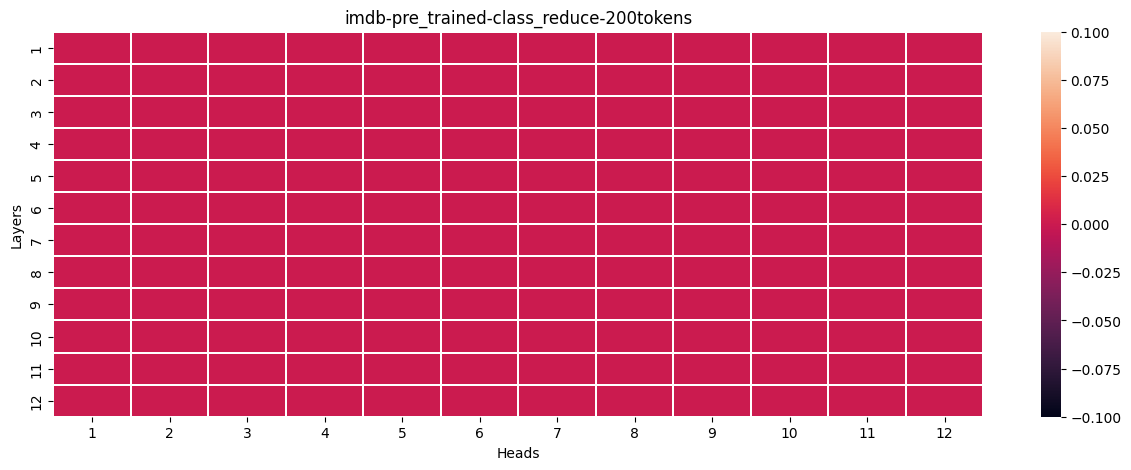

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# load the data
visualization = torch.load('../scores/rotten_tomatoes/class_reduce/200tokens/pre_trained/' + 'visualization.pt')

fig, ax = plt.subplots(figsize=(15,5))
xticklabels=list(range(1,13))
yticklabels=list(range(1,13))
ax = sns.heatmap(visualization.cpu().detach().numpy(), xticklabels=xticklabels, yticklabels=yticklabels, linewidth=0.2)
plt.xlabel('Heads')
plt.ylabel('Layers')
plt.title(config['dataset'] + '-' + config['model_info'] + '-' + config['target'] + '-'+ config['max_len'])
# plt.savefig(path + 'visualization_fig')
plt.show()

In [ ]:
!ls ../scores/rotten_tomatoes/NoneClass/50tokens/pre_trained/

attributions.pt


In [ ]:
!nano ../scores/rotten_tomatoes/NoneClass/50tokens/pre_trained/stats.txt

In [28]:
attributions_list = torch.load(path + 'attributions.pt')
print(len(attributions_list))
print(attributions_list[0].shape)

6
torch.Size([12, 12, 18, 18])


In [27]:
attentions_list = torch.load(path + 'attentions.pt')
print(len(attentions_list))
print(attentions_list[0].shape)

6
torch.Size([12, 12, 18, 18])


In [ ]:
import torch

a = torch.tensor([1, 2, 3, 4, 5, 6])
num_repeats = 3

b = a
# b = a.repeat(num_repeats).view(num_repeats, -1)

print(b)


In [ ]:
import torch

a = torch.tensor([1, 2, 3, 4, 5, 6])
num_copies = 3

# Using repeat
# b = a.unsqueeze(0).repeat(num_copies, 1)
b = a.repeat(num_repeats, 1).clone()

# b = a.unsqueeze(0).repeat(num_copies, 1).clone()

# b = a.unsqueeze(0).expand(num_copies, -1)
# Modifying the first element of b
b[0, 1] = 0
b[0, 3] = 0
b[0, 4] = 0
print(b)
print(a)  # This will print tensor([0, 2, 3, 4, 5, 6])
